# Использование предобученных трансформеров

In [1]:
# %pip install torch torchvision torchaudio
%pip install git+https://github.com/huggingface/transformers.git srsly triton

  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-edwz2c58
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-edwz2c58
  Resolved https://github.com/huggingface/transformers.git to commit b76caaa88d9de399ec8c2ad1338c69d31e4fef32
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 18.1 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 34.6 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 28.4 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.6/803.6 kB 23.4 MB/s  0:00:00
  Created wheel for transformers: filename=transformers-5.0.1.dev0-py3-none-any.whl size=11279131 sha256=cb6b2cc34d432c1e0d7f50ea02cc6be921eb397f185eb1b87fda8180dd80f1e8
  Stored in directory: /tmp/pip-ephem-wheel-cache-9h2956fi/wh

Большинство SOTA моделей последних лет основаны на 1 нейросетевой архитектуре, которая называется Transformer. Эта архитектура была представлена в 2017 году в статье - [Attention is all you need](https://arxiv.org/abs/1706.03762). 

На тот момент в обработке последовательностей доминировали рекуррентные нейроные сети, но у них была проблема с "забыванием" информации при обработке длинных текстов. Для решения этой проблемы был придуман механизм внимания (attention), который позволял на каждом шаге учитывать агрегированную информацию от всех предыдущих и последующих элементов. LSTM+Attention некоторое время был sota подходом, но в attention is all you need было показано, что можно получить те же результаты, используя по сути только механизм внимания, без рекуррентности. 

Отсутствие рекуррентности позволяет гораздо эффективнее распараллеливать вычисления как на 1 gpu/tpu так и на кластере. На тот момент уже было несколько исследований показывающих, что при увеличении количества параметров и данных, модели начинают вести себя неожиданно хорошо (например, у OpenAI была статья в которой они рассказывали, что оставили LSTM на несколько месяцев и потом обнаружили, что она научилась достаточно точно определять тональность текста (без обучения на размеченном датасете) - https://openai.com/blog/unsupervised-sentiment-neuron/). Рекуррентные сети не позволяли серьезно увеличивать размер сетей даже при наличие ресурсов, а трансформеры позволили. 

Все последующие годы регулярно появлялись (и продолжают появляться) все более и более объемные трансформерные модели (BERT, GPT-1,2,3, Megatron, PaLM, Lambda etc). Есть попытки масштабировать RNN модели тоже, но успешных примеров сильно меньше доступных трансформеров (стоит упомянуть [RWKV](https://github.com/BlinkDL/RWKV-LM) как самый удачный). 

Давайте попробуем чуть более подробно разобрать, как устроен трансформер. Это не простая тема и разбирать её мы будем постепенно.   
**В этом семинаре посмотрим в целом на архитектуру и ее ключевые элементы, а также попробуем использовать предобученные трансформерные модели (а точнее BERT) для задачи классификации.**

## Seq2seq

Для начала вернемся к рекуррентным сетям. Их недостатки наиболее серьезно проявились в задаче seq2seq. В seq2seq по входной последовательности нужно сгенерировать целевую последовательность, а длины последовательностей при этом могут отличаться. Самый каноничный пример seq2seq задачи - машинный перевод.

Использование LSTM* для машинного перевода можно схематически представить вот так:

*_тут и далее когда я говорю LSTM я на самом деле подразумеваю рекуррентные нейроные сети в целом, просто LSTM самый популярный их представитель, но уточнять это каждый раз неудобно_

![](https://i.ibb.co/XjP2Gmh/Lstm-seq2seq.png)

Для такой задачи нужно два LSTM слоя: один кодирует входную последовательность (encoder, или кодировщик), другой генерирует целевую последовательность (decoder или декодировщик). Такой подход работает, но есть серьезный недостаток - на вход декодеру подается только 1 вектор, в котором закодирована вся информация о целевой последовательности. Этот вектор - бутылочное горлышко (bottleneck), узкое место, в которое все упирается.

Если приводить аналогии, это как пытаться первести текст сходу целиком, прочитав его только 1 раз (попробуйте, например, перевести это предложение, не перечитывая). 

### Attention

Для устранения бутылочного горлышка стали использовать механизм внимания. Он дает декодирующей LSTM доступ ко всем состояниям энкодера, а не только к последнему. Это уже больше похоже на то, как человек переводит текст - текст прочитывается целиком, но при переводе можно возвращаться к каждому отдельному слову исходного текста.   

Схематично LSTM+Attention можно представить вот так. Такая архитектура уже в середине десятых годов позволила Google начать переход к нейронному переводу (до этого использовался статистический и правиловый):

![](https://i.ibb.co/bzwNqwC/lstm-attention-seq2seq.png)

Давайте подробнее посмотрим на механизм внимания. Визуализировать его целиком достаточно сложно, поэтому рассмотрим только 1 шаг (генерацию первого слова в переводе). 
![](https://i.ibb.co/19xB94B/lstm-attention-1-step.png)

Само внимание (или attention) можно реализовать разными способами. Мы рассмотрим один возможный подход - через скалярное произведение. 

После прохода энкодера для каждого элемента входной последовательности существует вектор состояния (его можно считать контекстным эмбедингом слова). На каждом шаге декодера между текущим состоянием декодера и всеми состояними энкодера расчитывается скалярное произведение (можно сказать считается близость между переводным словом и всеми словами входного текста). Результатом такого скалярного произведения является набор весов, соответствующих каждому слову входной последовательности. Эти веса показывают, какие слова релеванты для генерации текущего слова в переводе. 

Далее каждый вес умножается на соотвутсвующий ему вектор состояния энкодера и эти вектора прибавляются к текущему состоянию декодера (то есть происходит взвешенная сумма векторов слов входной последовательности и итоговая сумма прибавляется или конкатенируется к состояние декодера). 

Attention убрал существующий bottleneck, но обучать такие модели было очень тяжело, так как в основе был LSTM. В 2017 был предложен подход без использования рекуррентности - Transformer.

## Transformer 

Вот как схематично решается задача машинного перевода с помощью трансформера. Самим трансформером называется блок с вниманием и полносвязными слоями, то есть и энкодер и декодер состоят из идентичных трансформерных блоков. Как и другие слои - трансформерные блоки можно накладывать друг на друга. Количество таких блоков в энкодере и декодере - настраиваемый гиперпараметр модели. 
![](https://i.ibb.co/XY0GK2R/transformer.png)

В BERT используется masked language modelling и его архитектура выглядит как-то так (это тот же трансформер но только с одной частью, то есть в нем нет декодера и соответственно кросс аттеншена):

![](https://cdn.analyticsvidhya.com/wp-content/uploads/2022/09/22971fig-3.webp)

Давайте верхнеуровнего рассмотрим как работает attention. 

В трансформерных блоках также есть heads, нормализация и skip-связи, но пока мы их пропустим. 

Attention в трансформере конечно не такой простой как на примере выше. Давайте посмотрим на визуализацию из вот этого поста https://jalammar.github.io/illustrated-transformer/ (его имеет смысл почитать целиком)

Attention также вычисляется через скалаярное произведение, но оно считается не между векторами напрямую. 

Каждый эмбединг одтельного слова преобразуется в 3 отдельных вектора с помощью полносвязного слоя (умножения на матрицу). У них есть названия: query вектор, key вектор и value вектор.

![](https://jalammar.github.io/images/t/transformer_self_attention_vectors.png)

Attention score вычисляется с помощью скалярного произведения query вектора текущего слова и key векторов всех слов в последовательности. Результат скалярного произведения пропускается через softmax, чтобы получить вероятности (это и есть оценки внимания, attention scores, высокая вероятность означает, что на это слово нужно обратить внимание, а низкий - что слово на текущем шаге не важно). 

Далее выполняется взвешенная сумма всех value векторов (веса = attention скоры). Полученный вектор уже передается дальше в полносвязный слой. При наслаивании транформерных блоков друг на друга на втором слое вместо эмбединга слова уже будет использоваться вектор полученный из предыдущего блока.

![](https://jalammar.github.io/images/t/self-attention-output.png)

Но это еще не все. Это пример того, что называется self-attention - когда внимание расчитыватся между элементами одной последовательности. На схеме выше еще есть cross-attention. Он используется в декодере - query вектор тут получается из эмбедингов слов в целевой последовательности, а key и value вектора получаются из выходных векторов энкодера. Cross-attention связывает энкодер и декодер.

Self-attention также присутствует в декодере. При обучении seq2seq моделей на вход подаются сразу две последовательности (текст и его перевод, например), но целевая последовательность подается постепенно (по 1 слову) и задача декодера - по полной входной последовательности и имеющейся на данный момент целевой последовательности сгенерировать продолжение. При использовании обученной модели для перевода текста сначала в декодер передается пустая последовательсть (а точнее не пустая а с тегом SOS или start, можно тут вспомнить семинар по языковым моделям).

В трансформере еще много других технических деталей, но для использования пока будет достаточно интуитивного понимания.

## Использование предобученных моделей

Транформеры также можно обучать в self-supervised формате (как word2vec) и использовать готовую модель для transfer learning. В 2018 вышел BERT (https://arxiv.org/abs/1810.04805), который показал насколько хорошо эта идея работает. BERT - это трансформерная модель, которая обучалась восстанавливать пропуски в тексте и определять соседние предложения. Данные для обучения BERT генерируются синтетически из сырого текста (например, берется предложение из вики и в нем случайно удаляются 20% токенов и их нужно восстановить). Авторы показали, что если дообучение предобученной BERT модели позволяет получить state-of-the-art результаты в большом количестве задач. 

Самое замечательное в том, что BERT был выложен в открытый доступ и им можно легко воспользоваться.

Давайте попробуем взять предобученные BERT и дообучить его решать задачу классификации текста.

In [3]:
# %pip install scikit-learn pandas matplotlib -U

In [5]:
# стандартные библиотеки
import os, re
import numpy as np
from time import time
from sklearn.model_selection import train_test_split
import pandas as pd
from collections import Counter
from string import punctuation
import matplotlib.pyplot as plt
%matplotlib inline


import torch
from transformers import AutoModel
from transformers import AutoTokenizer

from tqdm.auto import tqdm
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report

Возьмем данные lenta.ru, но не целиком. Fine-tuning больших моделей лучше всего подходит, когда данных совсем мало и стандартным алгоритмам просто не хватает информации, чтобы обучиться. Поэтому возьмем только небольшой процент всех данных.

### Загружаем предобученную модель из huggingface transformers

Список всех доступных моделей можно найти тут - https://huggingface.co/models  
А вот тут основные с описанием - https://huggingface.co/transformers/pretrained_models.html

Другие виды моделей мы обсудим на следующем занятии, так как их очень много и они существенно отличаются друг от друга. Пока разберем 3 варианта BERT. 

# Zero short classification

In [8]:
# %pip install datasets

In [9]:
from datasets import load_dataset

In [125]:
# data = load_dataset('toxigen/toxigen-data', 'annotated')

In [211]:
# df = data['train'].to_pandas()

In [129]:
# data_eng = df[['text', 'target_group']].sample(frac=0.10)

In [130]:
# data_eng = data_eng.rename({'target_group': 'label'}, axis=1).reset_index(drop=True)

In [210]:
# data_eng.to_csv('target_group_classification_sample.csv', index=None)

Хотелось бы попробовать modernbert, но он только на английском, поэтому я нашел какой-то вот такой не очень простой датасет, где нужно определить категорию людей на которых нацелено высказивание в тексте

In [10]:
data_eng = pd.read_csv('target_group_classification_sample.csv')

In [11]:
data_eng

,text,label
0,bullying a serious issue for many students tha...,asian
1,islam is the religion of peace,middle_east
2,disabled children should be taken away from th...,physical_dis
3,muslims follow their religion to a point. They...,muslim
4,"""ha, i post this picture of a black guy on my ...",black
...,...,...
891,america is the greatest country in the history...,native_american
892,your kids cant be too traumatized by the fact ...,mental_dis
893,no one was killed everyone escaped unharmed no...,muslim
894,the best thing to do if you are in a car accid...,asian


In [12]:
data_eng['label'].value_counts()

label
mental_dis         84
muslim             78
chinese            74
middle_east        71
black              71
jewish             71
mexican            71
native_american    69
latino             65
physical_dis       63
women              62
lgbtq              59
asian              58
Name: count, dtype: int64

In [13]:
model_id = "answerdotai/ModernBERT-base"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModel.from_pretrained(model_id)

config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/599M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/134 [00:00<?, ?it/s]

ModernBertModel LOAD REPORT from: answerdotai/ModernBERT-base
Key               | Status     |  | 
------------------+------------+--+-
decoder.bias      | UNEXPECTED |  | 
head.dense.weight | UNEXPECTED |  | 
head.norm.weight  | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [14]:
tokenizer.encode('Some sentence' )

[50281, 6080, 6197, 50282]

In [20]:
# переводим индекс токена обратно в текст
encoded = tokenizer.encode('Some sentence')
[tokenizer.decode([x]) for x in encoded]

['[CLS]', 'Some', ' sentence', '[SEP]']

In [21]:
text = 'Some sentence'
text_ids = tokenizer.encode(text, add_special_tokens=True, 
                            return_tensors='pt') # преобразуем в торч формат 
output = model(text_ids, output_attentions=False)

На выходе мы получим tuple (из одного или двух элементов).

Первый элемент - состояния енкодера для каждого из элементов последовательности
(Опционально может еще быть второй элемент с пулинг вектором)

In [22]:
output[0].shape

torch.Size([1, 4, 768])

Обычно в задачах используют либо состояние первого элемента

In [23]:
output[0][:,0].shape

torch.Size([1, 768])

In [24]:
output[0][:,0]

tensor([[ 1.6130e-01,  5.0510e-02,  2.2991e-01,  6.5441e-02, -1.4778e-02,
          1.0118e-01,  8.0169e-02, -9.2621e-02, -8.4510e-02,  4.0091e-02,
          3.9619e-02,  6.1466e-02,  5.7449e-03,  5.5578e-02,  3.8156e-02,
          6.6571e-02, -2.9714e-03,  9.2564e-02,  6.9252e-02,  8.0735e-02,
          2.9929e-02,  1.2986e-01,  5.6116e-02,  1.5533e-01,  1.5863e-01,
         -6.6091e-02,  5.3939e-02, -3.8388e-02,  8.2978e-02,  6.5021e-02,
          7.5582e-02,  2.3549e+00,  7.9684e-02,  8.4581e-02, -6.4616e-02,
         -1.1243e-01, -3.0540e-02,  8.6366e-02,  1.0614e-01, -3.4537e-02,
          1.1136e-01,  1.1549e-01,  2.6748e-01,  4.6738e-02, -3.0881e-02,
          3.8125e-02,  2.4928e-01, -3.2599e-02, -2.6397e-02,  5.9737e-02,
          1.3704e-01, -4.8268e-02,  2.3512e-02,  9.2066e-02,  1.6358e-02,
          1.0816e-02,  1.4445e-01,  4.7808e-03, -1.5922e-02, -5.1765e-02,
          1.1172e-01,  4.2465e-03,  1.5116e-01, -1.7834e-04,  1.0256e-01,
         -8.4606e-02,  2.8071e-02, -6.

Давайте попробуем использовать эти эмбеддинги. 
Презже чем что-то обучать давайте попробуем zero shot classification. Это такой подход, когда мы используем сырые эмбединги и получаемся получить классы напрямую

Преобразуем все тексты в нашем датасете в вектора (возьмем CLS токен)

In [25]:
@torch.no_grad
def embed(text):
    text_ids = tokenizer.encode(text, add_special_tokens=True, 
                            return_tensors='pt')[:, :64] # преобразуем в торч формат 
    output = model(text_ids, output_attentions=False)
    
    return output[0][:,0]

In [26]:
X = np.zeros((data_eng.shape[0], 768))

for i, text in tqdm(enumerate(data_eng['text'])):    
    X[i] = embed(text).numpy()

0it [00:00, ?it/s]

In [27]:
y = data_eng['label'].values

In [28]:
train_index, valid_index = train_test_split(list(range(len(X))), test_size=0.1, stratify=data_eng['label'])

Прежде чем пробовать берт давайте все-таки сделаем бейзлайн на tfidf чтобы понимать от чего отталкиваться

In [30]:
vectorizer = TfidfVectorizer()
X_vec_train = vectorizer.fit_transform(data_eng['text'][train_index])
X_vec_valid = vectorizer.transform(data_eng['text'][valid_index])
y_train = y[train_index]
y_valid = y[valid_index]

clf = SGDClassifier()
clf.fit(X_vec_train, y_train)
preds = clf.predict(X_vec_valid)
print(classification_report(y_valid, preds))

                 precision    recall  f1-score   support

          asian       0.40      0.33      0.36         6
          black       0.20      0.14      0.17         7
        chinese       0.38      0.43      0.40         7
         jewish       0.57      0.57      0.57         7
         latino       0.50      0.43      0.46         7
          lgbtq       0.50      0.50      0.50         6
     mental_dis       0.50      0.44      0.47         9
        mexican       0.40      0.57      0.47         7
    middle_east       0.57      0.57      0.57         7
         muslim       0.71      0.62      0.67         8
native_american       0.50      0.71      0.59         7
   physical_dis       0.33      0.33      0.33         6
          women       0.40      0.33      0.36         6

       accuracy                           0.47        90
      macro avg       0.46      0.46      0.46        90
   weighted avg       0.46      0.47      0.46        90



Давайте попробуем knn. Это не совсем zero shot обучение, но все еще просто использование небольшого количества данных, которые у нас есть и расчет близости между эмбеддингами. 

In [31]:
X_train, y_train = X[train_index], y[train_index]
X_valid, y_valid = X[valid_index], y[valid_index]

In [32]:
clf = KNeighborsClassifier(3, metric='cosine')
clf.fit(X_train, y_train)

,"n_neighbors n_neighbors: int, default=5Number of neighbors to use by default for :meth:`kneighbors` queries.",3
,"weights weights: {'uniform', 'distance'}, callable or None, default='uniform'Weight function used in prediction. Possible values:- 'uniform' : uniform weights. All points in each neighborhood are weighted equally.- 'distance' : weight points by the inverse of their distance. in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.- [callable] : a user-defined function which accepts an array of distances, and returns an array of the same shape containing the weights.Refer to the example entitled:ref:`sphx_glr_auto_examples_neighbors_plot_classification.py`showing the impact of the `weights` parameter on the decisionboundary.",'uniform'
,"algorithm algorithm: {'auto', 'ball_tree', 'kd_tree', 'brute'}, default='auto'Algorithm used to compute the nearest neighbors:- 'ball_tree' will use :class:`BallTree`- 'kd_tree' will use :class:`KDTree`- 'brute' will use a brute-force search.- 'auto' will attempt to decide the most appropriate algorithm based on the values passed to :meth:`fit` method.Note: fitting on sparse input will override the setting ofthis parameter, using brute force.",'auto'
,"leaf_size leaf_size: int, default=30Leaf size passed to BallTree or KDTree. This can affect thespeed of the construction and query, as well as the memoryrequired to store the tree. The optimal value depends on thenature of the problem.",30
,"p p: float, default=2Power parameter for the Minkowski metric. When p = 1, this is equivalentto using manhattan_distance (l1), and euclidean_distance (l2) for p = 2.For arbitrary p, minkowski_distance (l_p) is used. This parameter is expectedto be positive.",2
,"metric metric: str or callable, default='minkowski'Metric to use for distance computation. Default is ""minkowski"", whichresults in the standard Euclidean distance when p = 2. See thedocumentation of `scipy.spatial.distance`_ andthe metrics listed in:class:`~sklearn.metrics.pairwise.distance_metrics` for valid metricvalues.If metric is ""precomputed"", X is assumed to be a distance matrix andmust be square during fit. X may be a :term:`sparse graph`, in whichcase only ""nonzero"" elements may be considered neighbors.If metric is a callable function, it takes two arrays representing 1Dvectors as inputs and must return one value indicating the distancebetween those vectors. This works for Scipy's metrics, but is lessefficient than passing the metric name as a string.",'cosine'
,"metric_params metric_params: dict, default=NoneAdditional keyword arguments for the metric function.",None
,"n_jobs n_jobs: int, default=NoneThe number of parallel jobs to run for neighbors search.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.Doesn't affect :meth:`fit` method.",None


In [33]:
preds = clf.predict(X_valid)

In [34]:
print(classification_report(y_valid, preds))

                 precision    recall  f1-score   support

          asian       0.00      0.00      0.00         6
          black       0.23      0.43      0.30         7
        chinese       0.00      0.00      0.00         7
         jewish       0.14      0.29      0.19         7
         latino       0.00      0.00      0.00         7
          lgbtq       0.00      0.00      0.00         6
     mental_dis       0.43      0.33      0.38         9
        mexican       0.25      0.14      0.18         7
    middle_east       0.25      0.14      0.18         7
         muslim       0.50      0.25      0.33         8
native_american       0.75      0.43      0.55         7
   physical_dis       1.00      0.17      0.29         6
          women       1.00      0.17      0.29         6

       accuracy                           0.19        90
      macro avg       0.35      0.18      0.21        90
   weighted avg       0.35      0.19      0.21        90



Можно также обучить логрег поверх эмбединнгов. Это мы уже делали раньше в word2vec семинаре. (Но это опять же не zero shot)

In [35]:
clf = SGDClassifier(loss='log_loss', n_iter_no_change=100)
clf.fit(X_train, y_train)
preds = clf.predict(X_valid)
print(classification_report(y_valid, preds))

                 precision    recall  f1-score   support

          asian       0.00      0.00      0.00         6
          black       0.50      0.57      0.53         7
        chinese       0.22      0.29      0.25         7
         jewish       0.40      0.29      0.33         7
         latino       0.50      0.29      0.36         7
          lgbtq       0.44      0.67      0.53         6
     mental_dis       0.62      0.56      0.59         9
        mexican       0.62      0.71      0.67         7
    middle_east       0.29      0.29      0.29         7
         muslim       0.46      0.75      0.57         8
native_american       0.50      0.43      0.46         7
   physical_dis       0.43      0.50      0.46         6
          women       0.40      0.33      0.36         6

       accuracy                           0.44        90
      macro avg       0.41      0.44      0.42        90
   weighted avg       0.42      0.44      0.43        90



/venv/main/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:733: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


#### Честный zero shot

Чтобы сделать zero shot классификацию по-честному, нам нужно забыть, что у нас есть обучающая выборка. Вместо нее мы можем использовать названия классов и сравнивать эмбединг текста с эмбедингом текстового названия класса.

Еще можно попытаться добавть какой-то темплейт вроде 'This text is about {}', но с этим нужно экспериментировать

In [36]:

y_classes = data_eng['label'].unique()
y_classes_text = ["{}".format(label) for label in y_classes]
X_classes = np.zeros((len(y_classes), 768))

for i, category in enumerate(y_classes_text):
    X_classes[i] = embed(category).numpy()


In [37]:
# y_classes

Близость можно рассчитать через dot product (умножение матриц) или использовать cosine_similarity

In [38]:
from sklearn.metrics.pairwise import cosine_similarity

In [39]:
X_valid.shape, X_classes.shape

((90, 768), (13, 768))

In [40]:
preds = (X_valid @ X_classes.T)
# preds = cosine_similarity(X_valid, X_classes)
preds = [y_classes[i] for i in preds.argmax(1)]

In [41]:
print(classification_report(y_valid, preds))

                 precision    recall  f1-score   support

          asian       0.00      0.00      0.00         6
          black       0.00      0.00      0.00         7
        chinese       0.00      0.00      0.00         7
         jewish       0.00      0.00      0.00         7
         latino       0.00      0.00      0.00         7
          lgbtq       0.00      0.00      0.00         6
     mental_dis       0.00      0.00      0.00         9
        mexican       0.00      0.00      0.00         7
    middle_east       0.25      0.29      0.27         7
         muslim       0.00      0.00      0.00         8
native_american       0.00      0.00      0.00         7
   physical_dis       0.07      1.00      0.14         6
          women       0.00      0.00      0.00         6

       accuracy                           0.09        90
      macro avg       0.02      0.10      0.03        90
   weighted avg       0.02      0.09      0.03        90



/venv/main/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/venv/main/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/venv/main/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Еще один zero shot подход уже более специфичный для BERT это использовать MASK токен и смотреть на вероятности, которые модель для него предсказывает. Можно токенизировать названия классов и сравнивать вероятности для нужных индексов и выбирать наиболее вероятный

In [42]:
# тут нужен другой класс, который включает и слой классификации из BERT
from transformers import AutoTokenizer, AutoModelForMaskedLM

model_id = "answerdotai/ModernBERT-base"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForMaskedLM.from_pretrained(model_id)

Loading weights:   0%|          | 0/137 [00:00<?, ?it/s]

In [43]:
tokenizer.all_special_ids

[50280, 50282, 50283, 50281, 50284]

In [44]:
tokenizer.all_special_tokens

['[UNK]', '[SEP]', '[PAD]', '[CLS]', '[MASK]']

In [55]:
# так как класс может токенизироваться в несколько токенов, возьмем только первый
class_token_ids = [t[0] for t in tokenizer.encode(list(y_classes), add_special_tokens=False)]


def zero_shot_from_mask(text):
    text_ids = tokenizer.encode(f'{text} [SEP] This text targets the following group: [MASK]', return_tensors='pt')
    with torch.no_grad():
        p = model(text_ids, output_attentions=False)
        # MASK токен - второй с конца
        # поэтому нам нужен второй с конца вектор
        pred = int(torch.nn.functional.softmax(p.logits[0, -2], dim=0)[class_token_ids].argmax())
        return y_classes[pred]

In [56]:
# tokenizer.encode(list(y_classes), add_special_tokens=False)

In [57]:
preds = data_eng.iloc[valid_index].text.apply(zero_shot_from_mask)

In [58]:
print(classification_report(y_valid, preds.values))

                 precision    recall  f1-score   support

          asian       0.36      0.67      0.47         6
          black       0.00      0.00      0.00         7
        chinese       0.00      0.00      0.00         7
         jewish       1.00      0.14      0.25         7
         latino       0.00      0.00      0.00         7
          lgbtq       0.00      0.00      0.00         6
     mental_dis       1.00      0.11      0.20         9
        mexican       0.00      0.00      0.00         7
    middle_east       0.00      0.00      0.00         7
         muslim       0.00      0.00      0.00         8
native_american       0.67      0.29      0.40         7
   physical_dis       0.00      0.00      0.00         6
          women       0.09      1.00      0.16         6

       accuracy                           0.16        90
      macro avg       0.24      0.17      0.11        90
   weighted avg       0.26      0.16      0.11        90



/venv/main/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/venv/main/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/venv/main/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


### Дообучение BERT

Но обычно даже если у нас совсем мало данных, то можно попробовать дообучить BERT 

In [207]:
# какие еще модели можно попробовать вместо modern bert

In [52]:
# # Можно сказать оригинальный берт
# tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
# model_bert = AutoModel.from_pretrained('bert-base-cased')

In [53]:
# # # # Мультиязычный оригинальный берт
# tokenizer = AutoTokenizer.from_pretrained('bert-base-multilingual-uncased')
# model_bert = AutoModel.from_pretrained('bert-base-multilingual-uncased')

In [54]:
# # # # дистилированный (т.е. уменьшенный) берт 
# tokenizer = AutoTokenizer.from_pretrained("distilbert-base-multilingual-cased")
# model_bert = AutoModel.from_pretrained("distilbert-base-multilingual-cased")

In [59]:
data = data_eng

Код для предобработки текста и создания обучающего датасета в torch (очень похоже на keras просто свой синтаксис и чуть больше вещей нужно делать вручную)

In [60]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data

In [61]:
from sklearn.metrics import f1_score

def train(model, iterator, optimizer, criterion, print_every=1000):
    
    epoch_loss = []
    epoch_f1 = []
    
    model.train()  

    for i, (texts, ys) in enumerate(iterator):
        
        optimizer.zero_grad()   
        predictions = model(texts.to(device)).squeeze()  
        loss = criterion(predictions, ys.to(device))        
        
        
        
        loss.backward()
        optimizer.step()     
        preds = predictions.detach().to('cpu').numpy().argmax(1).tolist()
        y_true = ys.tolist()
        
        epoch_loss.append(loss.item())
        epoch_f1.append(f1_score(y_true, preds, average="micro"))
        
        if not (i+1) % print_every:
            print(f'Loss: {np.mean(epoch_loss)}; F1 measure: {np.mean(epoch_f1)}')
        
    return np.mean(epoch_f1)


def evaluate(model, iterator, criterion):
    
    epoch_loss = []
    epoch_f1 = []
    
    model.eval()  
    with torch.no_grad():
        for texts, ys in iterator:   

            predictions = model(texts.to(device)).squeeze()  
            loss = criterion(predictions, ys.to(device))        
            preds = predictions.detach().to('cpu').numpy().argmax(1).tolist()
            y_true = ys.tolist()
            

            epoch_loss.append(loss.item())  
            epoch_f1.append(f1_score(y_true, preds, average="micro"))
            
    return np.mean(epoch_f1)# / len(iterator)

In [62]:
def predict(model, iterator):
    
    preds = []
    
    model.eval()  
    with torch.no_grad():
        for texts, ys in iterator:   
            predictions = model(texts.to(device)).squeeze()        
            ys = predictions.detach().to('cpu').numpy().argmax(1).tolist()
            preds.extend(ys)
            
    return preds

# BERT

Для дообучения мы можем попроботь два основных варианта - дообучать все или дообучать только один дополнительный слой

In [63]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, tokenizer, MAX_LEN, texts, targets):
        
        self.tokenizer = tokenizer
        self.texts = [torch.LongTensor(tokenizer.encode(t)[:MAX_LEN]) for t in texts]
        self.texts = torch.nn.utils.rnn.pad_sequence(self.texts, batch_first=True,
                                                     padding_value=self.tokenizer.pad_token_id)
        
        self.MAX_LEN = MAX_LEN
        self.length = len(texts)
        
        self.target = torch.LongTensor(targets)

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        ids = self.texts[index]
        y = self.target[index]

        return ids, y
    
    def preprocess(self, text):
        tokens = text.lower().split()
        tokens = [token.strip(punctuation) for token in tokens]
        tokens = [token for token in tokens if token]
        return tokens

In [64]:
from sklearn.metrics import f1_score

def train(model, iterator, optimizer, criterion, print_every=1000):
    
    epoch_loss = []
    epoch_f1 = []
    
    model.train()  

    for i, (texts, ys) in enumerate(iterator):
        
        optimizer.zero_grad()   
        predictions = model(texts.to(device)).squeeze()  
        loss = criterion(predictions, ys.to(device))        
        
        
        
        loss.backward()
        optimizer.step()     
        preds = predictions.detach().to('cpu').numpy().argmax(1).tolist()
        y_true = ys.tolist()
        
        epoch_loss.append(loss.item())
        epoch_f1.append(f1_score(y_true, preds, average="micro"))
        
        if not (i+1) % print_every:
            print(f'Loss: {np.mean(epoch_loss)}; F1 measure: {np.mean(epoch_f1)}')
        
    return np.mean(epoch_f1)


def evaluate(model, iterator, criterion):
    
    epoch_loss = []
    epoch_f1 = []
    
    model.eval()  
    with torch.no_grad():
        for texts, ys in iterator:   

            predictions = model(texts.to(device)).squeeze()  
            loss = criterion(predictions, ys.to(device))        
            preds = predictions.detach().to('cpu').numpy().argmax(1).tolist()
            y_true = ys.tolist()
            

            epoch_loss.append(loss.item())  
            epoch_f1.append(f1_score(y_true, preds, average="micro"))
            
    return np.mean(epoch_f1)# / len(iterator)

In [65]:
# в берте максимальная длина обычно ограничена 512
MAX_LEN = 512

In [66]:
texts = data.text.values
id2label = {i:l for i,l in enumerate(set(data.label))}
label2id = {l:i for i,l in id2label.items()}
targets = [label2id[l] for l in data.label]

In [67]:
train_texts, valid_texts, train_targets, valid_targets = train_test_split(texts, targets, test_size=0.05)

In [68]:
training_set = Dataset(tokenizer, MAX_LEN, train_texts, train_targets)
training_generator = torch.utils.data.DataLoader(training_set, batch_size=16, shuffle=True, )
valid_set = Dataset(tokenizer, MAX_LEN, valid_texts, valid_targets)
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=16, shuffle=True)

In [69]:
import torch.nn as nn

class CLF(nn.Module):
    
    def __init__(self, pretrained_model, num_classes):
        super().__init__()          
        self.tokenizer = tokenizer # токенизатор
        self.pretrained_model = pretrained_model # предобученная модель
        #
        self.drop = nn.Dropout(0.3) # добавим дропаут чтобы не переобучалось
        self.fc = nn.Linear(768, num_classes) 
        self.act = nn.LogSoftmax(1) 
        
    def forward(self, texts):
        
        mask = (texts != tokenizer.pad_token_id).long()
        
        # прогоняем через BERT
        hidden = self.pretrained_model(texts, attention_mask=mask)[0]

        # берем самое первое состояние и применяем к нему линейный слой и активацию
        dense_outputs=self.fc(self.drop(hidden[:,0] ))
        outputs=self.act(dense_outputs)
        
        return outputs

#### Дообучение с заморозкой берта

In [70]:
model_id = "answerdotai/ModernBERT-base"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model_bert = AutoModel.from_pretrained(model_id)

for param in model_bert.parameters():
    param.requires_grad = False

Loading weights:   0%|          | 0/134 [00:00<?, ?it/s]

ModernBertModel LOAD REPORT from: answerdotai/ModernBERT-base
Key               | Status     |  | 
------------------+------------+--+-
decoder.bias      | UNEXPECTED |  | 
head.dense.weight | UNEXPECTED |  | 
head.norm.weight  | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [71]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
model = CLF(model_bert, len(label2id))
optimizer = optim.Adam(model.parameters(), lr=2e-4)
criterion = nn.NLLLoss() 
model = model.to(device)
criterion = criterion.to(device)

In [72]:
print("Percentage of trainable params:")
print('{0:.10f}'.format(sum(p.numel() for p in model.parameters() if p.requires_grad)/sum(p.numel() for p in model.parameters())))

Percentage of trainable params:
0.0000670830


In [73]:
f1s = []
f1s_eval = []

for i in range(40):
    print(i)
    f1s.append(train(model, training_generator, optimizer, criterion, 2000))
    evl = evaluate(model, valid_generator, criterion)
    print('Eval - ', evl)
    f1s_eval.append(evl)

0


/venv/main/lib/python3.12/site-packages/torch/_inductor/compile_fx.py:321: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  warnings.warn(


Eval -  0.2740384615384615
1
Eval -  0.1762820512820513
2
Eval -  0.3157051282051282
3
Eval -  0.2948717948717949
4
Eval -  0.32051282051282054
5
Eval -  0.2548076923076923
6
Eval -  0.21794871794871795
7
Eval -  0.3365384615384615
8
Eval -  0.3621794871794872
9
Eval -  0.28044871794871795
10
Eval -  0.2740384615384615
11
Eval -  0.2900641025641026
12
Eval -  0.2644230769230769
13
Eval -  0.25961538461538464
14
Eval -  0.2852564102564103
15
Eval -  0.2852564102564103
16
Eval -  0.32211538461538464
17
Eval -  0.2852564102564103
18
Eval -  0.2900641025641026
19
Eval -  0.3060897435897436
20
Eval -  0.3108974358974359
21
Eval -  0.2900641025641026
22
Eval -  0.3317307692307692
23
Eval -  0.32051282051282054
24
Eval -  0.3317307692307692
25
Eval -  0.2900641025641026
26
Eval -  0.2852564102564103
27
Eval -  0.2483974358974359
28
Eval -  0.2692307692307692
29
Eval -  0.2852564102564103
30
Eval -  0.3108974358974359
31
Eval -  0.2852564102564103
32
Eval -  0.3621794871794872
33
Eval -  0.322

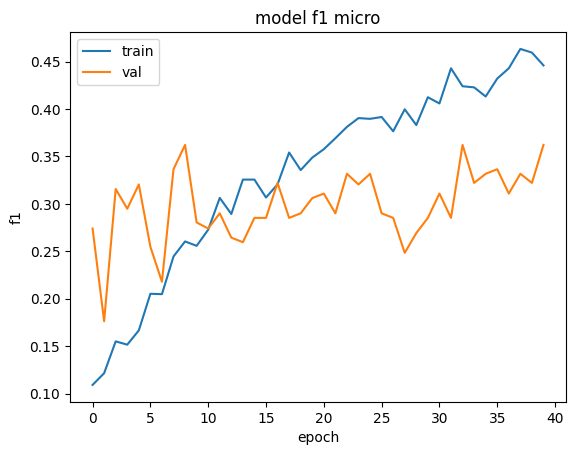

In [74]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('model f1 micro')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [75]:
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=False)
preds = predict(model, valid_generator)

In [76]:
print(classification_report(valid_targets, preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         4
           2       0.40      0.40      0.40         5
           3       0.71      0.83      0.77         6
           4       0.75      0.50      0.60         6
           5       0.00      0.00      0.00         3
           6       0.00      0.00      0.00         2
           7       1.00      0.25      0.40         4
           8       0.33      0.25      0.29         4
           9       0.00      0.00      0.00         1
          10       0.20      1.00      0.33         2
          11       1.00      0.50      0.67         4
          12       0.00      0.00      0.00         3

    accuracy                           0.36        45
   macro avg       0.34      0.29      0.27        45
weighted avg       0.46      0.36      0.36        45



/venv/main/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/venv/main/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/venv/main/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


### Дообучение без замораживания bert

In [77]:
model_id = "answerdotai/ModernBERT-base"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model_bert = AutoModel.from_pretrained(model_id)

Loading weights:   0%|          | 0/134 [00:00<?, ?it/s]

ModernBertModel LOAD REPORT from: answerdotai/ModernBERT-base
Key               | Status     |  | 
------------------+------------+--+-
decoder.bias      | UNEXPECTED |  | 
head.dense.weight | UNEXPECTED |  | 
head.norm.weight  | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [78]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
model = CLF(model_bert, len(label2id))
optimizer = optim.Adam(model.parameters(), lr=2e-4)
criterion = nn.NLLLoss() 
model = model.to(device)
criterion = criterion.to(device)

In [79]:
print("Percentage of trainable params:")
print('{0:.10f}'.format(sum(p.numel() for p in model.parameters() if p.requires_grad)/sum(p.numel() for p in model.parameters())))


Percentage of trainable params:
1.0000000000


In [80]:
f1s = []
f1s_eval = []

for i in range(30):
    print(i)
    f1s.append(train(model, training_generator, optimizer, criterion, 2000))
    evl = evaluate(model, valid_generator, criterion)
    print('Eval - ', evl)
    f1s_eval.append(evl)

0
Eval -  0.1622596153846154
1
Eval -  0.1935096153846154
2
Eval -  0.3173076923076923
3
Eval -  0.29447115384615385
4
Eval -  0.4807692307692308
5
Eval -  0.4723557692307692
6
Eval -  0.4879807692307692
7
Eval -  0.4879807692307692
8
Eval -  0.5192307692307692
9
Eval -  0.5120192307692308
10
Eval -  0.5120192307692308
11
Eval -  0.4963942307692308
12
Eval -  0.5432692307692308
13
Eval -  0.5661057692307692
14
Eval -  0.5120192307692308
15
Eval -  0.5276442307692308
16
Eval -  0.5276442307692308
17
Eval -  0.5276442307692308
18
Eval -  0.5276442307692308
19
Eval -  0.5276442307692308
20
Eval -  0.5276442307692308
21
Eval -  0.5276442307692308
22
Eval -  0.5276442307692308
23
Eval -  0.5276442307692308
24
Eval -  0.5276442307692308
25
Eval -  0.5276442307692308
26
Eval -  0.5276442307692308
27
Eval -  0.5276442307692308
28
Eval -  0.5276442307692308
29
Eval -  0.5276442307692308


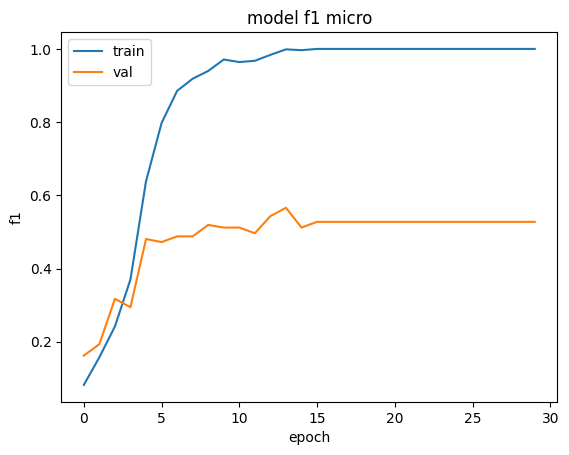

In [81]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('model f1 micro')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [82]:
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=False)
preds = predict(model, valid_generator)

In [83]:
print(classification_report(valid_targets, preds))

              precision    recall  f1-score   support

           0       0.14      1.00      0.25         1
           1       1.00      0.25      0.40         4
           2       0.67      0.80      0.73         5
           3       0.71      0.83      0.77         6
           4       1.00      0.50      0.67         6
           5       0.67      0.67      0.67         3
           6       0.50      0.50      0.50         2
           7       0.67      0.50      0.57         4
           8       0.33      0.25      0.29         4
           9       0.00      0.00      0.00         1
          10       0.67      1.00      0.80         2
          11       0.60      0.75      0.67         4
          12       0.00      0.00      0.00         3

    accuracy                           0.56        45
   macro avg       0.54      0.54      0.48        45
weighted avg       0.63      0.56      0.55        45

